# Deep learning labs, part 1

## Imports

In [85]:
from glob import glob
import json
from urllib.request import urlretrieve
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV)

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything

from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)

from ISLP import load_data
from ISLP.models import ModelSpec as MS
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)

seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


## Single layer network on Hitters data

### Hitters data

In [2]:
Hitters = load_data('Hitters').dropna()
Hitters.shape

(263, 20)

### Train/test split

In [3]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
y = Hitters['Salary'].to_numpy()
X.shape, y.shape

((263, 19), (263,))

In [4]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=1/3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((175, 19), (88, 19), (175,), (88,))

### Linear models

We evaluate the models using mean absolute error (MAE).

$$MAE(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} \left\lvert y_i - \hat{y_i} \right\rvert$$

In [5]:
hit_lm = LinearRegression().fit(X_train, y_train)
yhat_test = hit_lm.predict(X_test)
np.abs(yhat_test - y_test).mean()

259.71528833146243

In [6]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline([
    ('scaler', scaler),
    ('lasso', lasso),
])

TODO: figure out the derivation of `lam_max`

In [7]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(y_train - y_train.mean())).max() / n
param_grid = {
    'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max,
}
param_grid

{'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
        212.25138966, 202.60423642, 193.39556119, 184.60543446,
        176.21483255, 168.20559645, 160.5603925 , 153.26267486,
        146.29664975, 139.64724123, 133.3000586 , 127.24136521,
        121.45804878, 115.93759301, 110.66805048, 105.63801679,
        100.83660589,  96.25342653,  91.87855974,  87.7025374 ,
         83.71632172,  79.9112857 ,  76.27919443,  72.81218732,
         69.50276103,  66.34375328,  63.3283273 ,  60.44995709,
         57.70241324,  55.07974951,  52.57628988,  50.18661637,
         47.9055572 ,  45.72817569,  43.64975953,  41.66581059,
         39.7720352 ,  37.96433481,  36.23879721,  34.59168794,
         33.01944234,  31.51865773,  30.08608609,  28.71862704,
         27.41332112,  26.16734337,  24.97799723,  23.8427087 ,
         22.7590208 ,  21.72458818,  20.73717211,  19.79463564,
         18.8949389 ,  18.03613476,  17.2163646 ,  16.43385426,
         15.68691022,  14.97391

In [8]:
cv = KFold(10, shuffle=True, random_state=1)
grid = GridSearchCV(
    lasso, param_grid, 
    cv=cv, scoring='neg_mean_absolute_error',
)
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Lasso(max_iter=30000, warm_start=True),
             param_grid={'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45...
        10.81237873,  10.32093943,   9.8518368 ,   9.40405561,
         8.97662677,   8.56862523,   8.17916799,   7.80741218,
         7.45255325,   7.1138232 ,   6.79048896,   6.48185076,
         6.18724064,   5.906021  ,   5.63758323,   5.38134637,
         5.13675587,   4.90328239,   4.68042064,   4.4676883 ,
         4.26462497,   4.07079118,   3.88576744,   3.70915331,
         3.54056657,   3.37964236,   3.2260324 ,   3.07940424,
         2.93944057,   2.80583846,   2.67830877,   2.5565755 ])},
             scoring='neg_mean_absolute_error')

In [9]:
trained_lasso = grid.best_estimator_
yhat_test = trained_lasso.predict(X_test)
np.fabs(yhat_test - y_test).mean()

257.2382010799497

### Specifying a network: classes and inheritance

In [10]:
class HittersModel(nn.Module):
    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [11]:
hit_model = HittersModel(X.shape[1])

In [12]:
summary(
    hit_model, 
    input_size=X_train.shape, 
    col_names=[
        'input_size', 
        'output_size', 
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

Convert `numpy.ndarray` data to `torch.tensor`.

In [14]:
X_train_t = torch.tensor(X_train.astype(np.float32))
y_train_t = torch.tensor(y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, y_train_t)

In [15]:
X_test_t = torch.tensor(X_test.astype(np.float32))
y_test_t = torch.tensor(y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, y_test_t)

In [16]:
max_num_workers = rec_num_workers()
max_num_workers

8

In [17]:
hit_dm = SimpleDataModule(
    hit_train, 
    hit_test,
    batch_size=32,
    num_workers=min(4, max_num_workers),
    validation=hit_test
)

In [18]:
hit_module = SimpleModule.regression(
    hit_model,
    metrics={'mae': MeanAbsoluteError()},
)

In [19]:
hit_logger = CSVLogger('logs', name='hitters')

NN training with Lightning `Trainer`.

In [20]:
hit_trainer = Trainer(
    deterministic=True,
    max_epochs=50,
    log_every_n_steps=5,
    logger=hit_logger,
    callbacks=[ErrorTracker()],
    enable_progress_bar=0,
)
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources packa

In [21]:
hit_trainer.test(hit_module, datamodule=hit_dm)

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             107904.6328125
        test_mae            221.83148193359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 107904.6328125, 'test_mae': 221.83148193359375}]

In [22]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [23]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],[training_legend, valid_legend]):
        results.plot(
            x='epoch',
            y=column,
            label=label,
            marker='o',
            color=color,
            ax=ax, alpha=.8,
        )
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

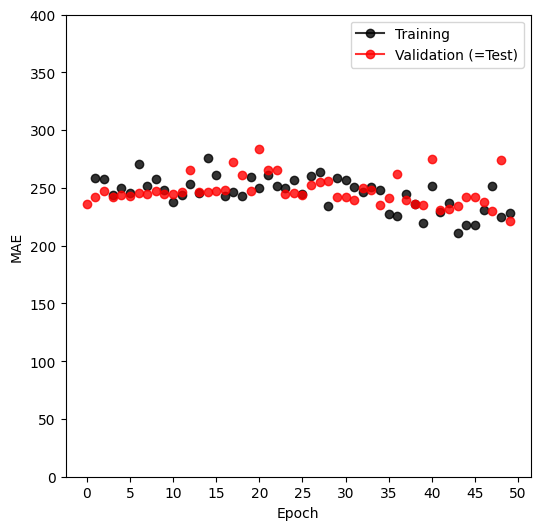

In [24]:
_, ax = plt.subplots(figsize=(6, 6))
ax = summary_plot(
    hit_results,
    ax,
    col='mae',
    ylabel='MAE',
    valid_legend='Validation (=Test)',
)
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

Evaluate model on test data.

In [25]:
hit_model.eval() 
preds = hit_module(X_test_t)
torch.abs(y_test_t - preds).mean()

tensor(221.8315, grad_fn=<MeanBackward0>)

### Cleanup

In [26]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, y,
    X_test, X_train,
    y_test, y_train,
    X_test_t, y_test_t,
    hit_trainer, hit_module)

## Multilayer network on the MNIST digit data

### MNIST data

In [29]:
mnist_train = MNIST(root='data', train=True, download=True, transform=ToTensor())
mnist_test = MNIST(root='data', train=False, download=True, transform=ToTensor())

In [30]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [31]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [32]:
mnist_dm = SimpleDataModule(
    mnist_train, mnist_test,
    validation=.2,
    num_workers=max_num_workers,
    batch_size=256,
)

Inspecting data batches.

In [43]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print(f'{idx}, X: {X_.shape}, Y: {Y_.shape}')
    if idx >= 1:
        break

0, X: torch.Size([256, 1, 28, 28]), Y: torch.Size([256])
1, X: torch.Size([256, 1, 28, 28]), Y: torch.Size([256])


### MNIST model

In [46]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10),
        )
    def forward(self, x):
        return self._forward(x)

In [47]:
mnist_model = MNISTModel()

In [48]:
mnist_model(X_).size()

torch.Size([256, 10])

In [49]:
summary(
    mnist_model,
    input_data=X_,
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

#### MNIST training

In [50]:
mnist_module = SimpleModule.classification(mnist_model, num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')

In [ ]:
mnist_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    logger=mnist_logger,
    callbacks=[ErrorTracker()],
)
mnist_trainer.fit(mnist_module, datamodule=mnist_dm)

Summary plots.

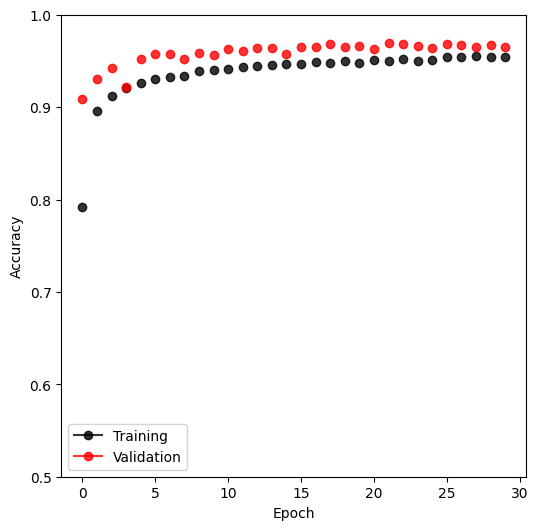

In [53]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
_, ax = plt.subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));

#### MNIST test

In [54]:
mnist_trainer.test(mnist_module, datamodule=mnist_dm)

Testing DataLoader 0:   2%|███▋                                                                                                                                             | 1/40 [00:00<00:00, 218.67it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Testing DataLoader 0:  40%|██████████████████████████████████████████████████████████                                                                                       | 16/40 [00:00<00:00, 33.90it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9657999873161316
        test_loss           0.13772235810756683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.13772235810756683, 'test_accuracy': 0.9657999873161316}]

### MNIST MLR

MNIST multiclass logistic regression with torch.

In [55]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [57]:
summary(
    mlr_model,
    input_data=X_,
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNIST_MLR                                [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Flatten: 2-1                      [256, 1, 28, 28]          [256, 784]                --
│    └─Linear: 2-2                       [256, 784]                [256, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 2.01
Input size (MB): 0.80
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.85

#### MNIST MLR training

In [ ]:
mlr_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    callbacks=[ErrorTracker()],
)
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

#### MNIST MLR test

In [58]:
mlr_trainer.test(mlr_module, datamodule=mnist_dm)

Testing: |                                                                                                                                                                            | 0/? [00:00<?, ?it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Testing DataLoader 0:  40%|█████████████████████████████████████████████████████████▌                                                                                      | 16/40 [00:00<00:00, 135.17it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 216.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9200000166893005
        test_loss            0.33269003033638
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.33269003033638, 'test_accuracy': 0.9200000166893005}]

### Cleanup

In [ ]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

## Convolutional neural networks

### CIFAR data

In [64]:
cifar_train = CIFAR100(root='data', train=True, download=True)
cifar_test = CIFAR100(root='data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
cifar_train

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train

In [66]:
cifar_test

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: data
    Split: Test

In [67]:
transform = ToTensor()
cifar_train_stack = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_stack = torch.stack([transform(x) for x in cifar_test.data])
cifar_train = TensorDataset(
    cifar_train_stack,
    torch.tensor(cifar_train.targets),
)
cifar_test = TensorDataset(
    cifar_test_stack,
    torch.tensor(cifar_test.targets),
)

CIFAR data module.

In [68]:
cifar_dm = SimpleDataModule(
    cifar_train, cifar_test,
    validation=0.2,
    num_workers=max_num_workers,
    batch_size=128,
)

Inspecting data batches.

In [69]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print(f'{idx}, X: {X_.shape}, Y: {Y_.shape}')
    if idx >= 1:
        break

0, X: torch.Size([128, 3, 32, 32]), Y: torch.Size([128])
1, X: torch.Size([128, 3, 32, 32]), Y: torch.Size([128])


### Images from CIFAR

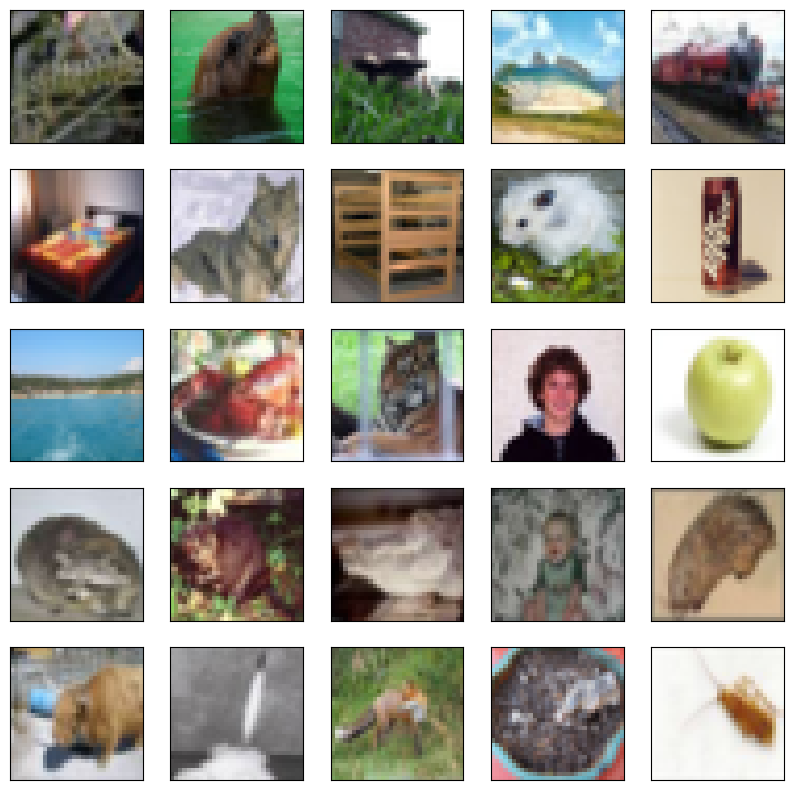

In [70]:
rng = np.random.default_rng(4)
indices = rng.choice(
    np.arange(len(cifar_train)), 
    25,
    replace=False,
).reshape((5, 5))

_, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        idx = indices[i, j]
        axes[i, j].imshow(
            np.transpose(cifar_train[idx][0],[1, 2, 0]),
            interpolation=None,
        )
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

### CIFAR model

Basic building block of CIFAR convolutional network.

In [71]:
class BuildingBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels
    ):
        super(BuildingBlock, self).__init__()
        # 3x3 conv filter
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding='same',
        )
        self.activation = nn.ReLU()
        # 2x2 max pool
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

CIFAR network model.

In [72]:
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [
            (3,32),
            (32,64),
            (64,128),
            (128,256),
        ]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2*2*256, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
        )

    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

CIFAR model summary.

In [73]:
cifar_model = CIFARModel()
summary(
    cifar_model,
    input_data=X_,
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

#### CIFAR module setup

Custom optimizer for CIFAR.

In [74]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)

Classification module and logger as before.

In [76]:
cifar_module = SimpleModule.classification(
    cifar_model,
    num_classes=100,
    optimizer=cifar_optimizer,
)
cifar_logger = CSVLogger('logs', name='CIFAR100')

#### CIFAR training

In [ ]:
cifar_trainer = Trainer(
    deterministic=True,
    max_epochs=30,
    logger=cifar_logger,
    callbacks=[ErrorTracker()],
)
cifar_trainer.fit(cifar_module, datamodule=cifar_dm)

Validation and training accuracy.

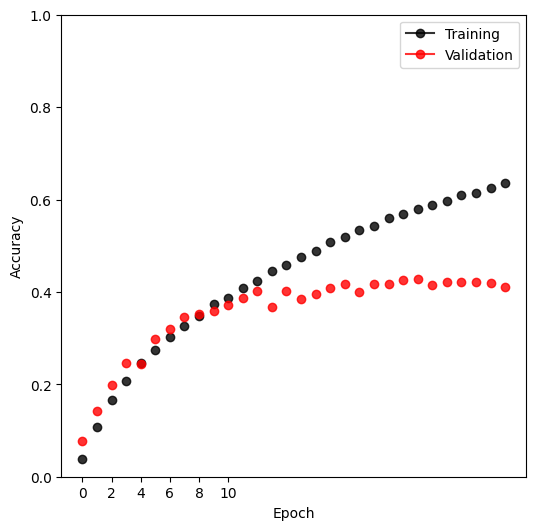

In [78]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)

_, ax = plt.subplots(1, 1, figsize=(6, 6))

summary_plot(cifar_results, ax, col='accuracy', ylabel='Accuracy')

ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

#### CIFAR test

In [79]:
cifar_trainer.test(cifar_module, datamodule=cifar_dm)

Testing: |                                                                                                                                                                            | 0/? [00:00<?, ?it/s]

/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/python3.10/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
/Users/sf/miniforge/envs/islp/lib/pyt

Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4147999882698059
        test_loss            2.476064920425415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.476064920425415, 'test_accuracy': 0.4147999882698059}]

### Hardware acceleration

In [ ]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(
        accelerator='mps',
        deterministic=True,
        max_epochs=30,
    )
    cifar_trainer_mps.fit(
        cifar_module,
        datamodule=cifar_dm,
    )
    cifar_trainer_mps.test(
        cifar_module,
        datamodule=cifar_dm,
    )
except:
    pass

## Pre-trained CNN models

### Download book_images.zip

In [83]:
book_images_url = 'https://hastie.su.domains/ISLP/Labs/data/book_images/book_images.zip'
book_images_filename = 'book_images.zip'
try:
    urlretrieve(book_images_url, book_images_filename)
    print(f"File '{book_images_filename}' downloaded successfully.")
except Exception as e:
    print(f"Error downloading file: {e}")

File 'book_images.zip' downloaded successfully.


### Unzip book_images.zip

In [87]:
book_images_dir = 'book_images'
with ZipFile(book_images_filename, 'r') as zip_object:
    zip_object.extractall(path=book_images_dir)

### Load book_images

In [88]:
resize = Resize((232, 232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406],
                      [0.229, 0.224, 0.225])
imgfiles = sorted([f for f in glob(f'{book_images_dir}/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([6, 3, 224, 224])

### resnet50 model

In [89]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(
    resnet_model,
    input_data=imgs,
    col_names=[
        'input_size',
        'output_size',
        'num_params',
    ],
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/sf/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:48<00:00, 2.10MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

#### Prediction with resnet

In [90]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [91]:
img_preds = resnet_model(imgs)

Predicted probabilities.

In [92]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

imagenet class indices.

In [96]:
imagenet_class_index_url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
imagenet_class_index_filename = 'imagenet_class_index.json'
try:
    urlretrieve(imagenet_class_index_url, imagenet_class_index_filename)
    print(f"File '{imagenet_class_index_filename}' downloaded successfully.")
except Exception as e:
    print(f"Error downloading file: {e}")

File 'imagenet_class_index.json' downloaded successfully.


In [97]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame(
    [(int(k), v[1]) for k, v in  labs.items()],
    columns=['idx', 'label'],
)
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

Top 3 labels with highest probabilities.

In [98]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images/Cape_Weaver.jpg
      label      prob
0   jacamar  0.297499
1     macaw  0.068107
2  lorikeet  0.051105
Image: book_images/Flamingo.jpg
            label      prob
0        flamingo  0.609515
1       spoonbill  0.013586
2  American_egret  0.002132
Image: book_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184682
1           robin  0.084021
2  great_grey_owl  0.061274
Image: book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.453833
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097196
2  Tibetan_terrier  0.032820
Image: book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


### Cleanup

In [99]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)